# Trabalho Final - Deep Learning and Reinforcement Learning

### Integrantes:

###    1) Jurandir Ventura - RM336634
###    2) Marcelo Preto - RM336632
###    3) Fabio Rizzi - RM336656
###    4) Thiago Alexandre – RM336583

## Keras

## Exercício #5.1 (OBRIGATÓRIO) - 2 PONTOS

### Utilizando o dataset do Exercício5.1.csv (disponível no repositório da disciplina) construa um modelo sequencial ou funcional no Keras para fazer a classificação desse dataset que é multiclass.

### Tente calibrar a quantidade de camadas e neurônios a fim de atingir uma taxa de acerto superior a 75% no conjunto de teste.

* Aplique os pré-processamentos necessários.
* Apresente a evolução do conjunto de treino e validação.
* Apresente a acurácia do conjunto de testes.
* Apresente a configuração (estrutura) da rede neural.
* O modelo não pode estar superajustado (“overfitado”) utilize as técnicas vistas em sala de aula para prevenir ou mitigar esse problema.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

random_state=42


In [2]:
# Features
X=pd.read_csv("data/ex5.1-dataset.csv", delimiter=';', encoding='UTF-8').astype(float)
# Classes
y=pd.read_csv("data/ex5.1-classes.csv", delimiter=';', encoding='UTF-8').astype(float)

# 1. Explorando o dataset

In [3]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.732337,-0.460087,0.410588,1.387655,1.549960,-0.309028,-0.119034,-1.710895,-2.103701,0.270298,-0.951528,-1.738395,2.242746,-0.062398,3.600965,0.506660,-0.351065
1,-1.697668,-3.658057,-0.067462,-0.307627,-3.257361,3.018813,0.506056,-1.943546,-0.781291,-1.054938,-0.903841,-0.971778,0.725666,-0.288371,2.136540,-0.172262,-3.538182
2,-0.009419,-2.079725,0.695339,1.395909,-1.152059,-0.149841,-1.748309,0.663311,0.243399,-0.468567,-1.793045,0.313092,0.156787,0.646463,0.872121,-0.876460,-0.159286
3,-0.955029,2.413873,-0.239355,0.296029,0.785301,-2.146341,1.792001,0.023154,-0.379947,1.025835,0.083103,1.352882,0.061962,0.043511,-1.387151,1.786397,0.813789
4,2.282446,0.764661,0.385960,-3.203398,0.165334,2.816127,-0.592895,-0.460681,1.613249,-0.383905,1.345218,0.173645,1.299997,-0.356091,-2.358184,0.142573,-1.503465


#### 17 features

In [4]:
y.head()

,0
0,7.0
1,4.0
2,6.0
3,5.0
4,1.0


In [5]:
sorted(y['0'].unique())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

#### 8 classes

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       30000 non-null  float64
 1   1       30000 non-null  float64
 2   2       30000 non-null  float64
 3   3       30000 non-null  float64
 4   4       30000 non-null  float64
 5   5       30000 non-null  float64
 6   6       30000 non-null  float64
 7   7       30000 non-null  float64
 8   8       30000 non-null  float64
 9   9       30000 non-null  float64
 10  10      30000 non-null  float64
 11  11      30000 non-null  float64
 12  12      30000 non-null  float64
 13  13      30000 non-null  float64
 14  14      30000 non-null  float64
 15  15      30000 non-null  float64
 16  16      30000 non-null  float64
dtypes: float64(17)
memory usage: 3.9 MB


In [7]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       30000 non-null  float64
dtypes: float64(1)
memory usage: 234.5 KB


In [8]:
y['0'].value_counts()

4.0    3784
6.0    3773
7.0    3762
2.0    3756
3.0    3753
1.0    3726
0.0    3725
5.0    3721
Name: 0, dtype: int64

#### Não há valores ausentes e a variável target está relativamente balanceada.

## 2. Normalizando dataset de features

In [9]:
SS=StandardScaler()
SS.fit_transform(X);

## 3. One-hot encoding das classes

In [10]:
# One-Hot encoding da coluna de classes
# Referencia: https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970
y=pd.get_dummies(y['0'])

In [11]:
y.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0


## 4. Dividindo amostras

In [12]:
# # Exemplo divisao manual do dataset:
# #     - 70% para treino: X_train, y_train
# #     - 15% para validação: X_val, y_val
# #     - 15% para teste: X_test, y_test
# #  Separo 85% para (treino + validação) e 15% para teste
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)
# #  Dos 85% de [treino + teste] separo em validação (0.1765*0.85 = 15% do total) e treino (70%)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=random_state) 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=random_state)

## 5. Modelo

In [14]:
# modelo sequencial
model = Sequential()

model.add(Dense(512, input_dim=X.shape[1], activation='relu')) # 17 features
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               9216      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32768     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               5

## 6. Treinamento

In [15]:
validation_split=0.1

total_samples=X_train.shape[0] + X_test.shape[0]
validation_samples=X_train.shape[0]*validation_split
train_samples=X_train.shape[0] - validation_samples
test_samples=X_test.shape[0]

print(total_samples, "total samples\n")
print(train_samples, 'train samples')
print(test_samples, 'test samples')
print(validation_samples, 'validation samples')

print("train:test:validation ratio = ", train_samples/total_samples, test_samples/total_samples, validation_samples/total_samples)

30000 total samples

22410.0 train samples
5100 test samples
2490.0 validation samples
train:test:validation ratio =  0.747 0.17 0.083


In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint(filepath='modelo-5.1.hdf5', verbose=1, save_best_only=True, monitor='val_accuracy')
try:
    # hist = model.fit(X_train, y_train, batch_size=64, epochs=300, validation_data=(X_val, y_val), callbacks=[es, mc], verbose=1, shuffle=True)
    hist = model.fit(X_train, y_train, batch_size=128, epochs=600, callbacks=[es, mc], verbose=1, shuffle=True, validation_split=validation_split)
except KeyboardInterrupt:
    hist = model.history

Epoch 1/600
157/176 [=========================>....] - ETA: 0s - loss: 1.4201 - accuracy: 0.5070
Epoch 00001: val_accuracy improved from -inf to 0.63333, saving model to modelo-5.1.hdf5
176/176 [==============================] - 1s 4ms/step - loss: 1.4011 - accuracy: 0.5154 - val_loss: 1.2015 - val_accuracy: 0.6333
Epoch 2/600
154/176 [=========================>....] - ETA: 0s - loss: 1.1435 - accuracy: 0.6326
Epoch 00002: val_accuracy improved from 0.63333 to 0.68876, saving model to modelo-5.1.hdf5
176/176 [==============================] - 0s 3ms/step - loss: 1.1397 - accuracy: 0.6333 - val_loss: 1.0190 - val_accuracy: 0.6888
Epoch 3/600
158/176 [=========================>....] - ETA: 0s - loss: 1.0516 - accuracy: 0.6681
Epoch 00003: val_accuracy improved from 0.68876 to 0.70964, saving model to modelo-5.1.hdf5
176/176 [==============================] - 1s 3ms/step - loss: 1.0490 - accuracy: 0.6696 - val_loss: 0.9788 - val_accuracy: 0.7096
Epoch 4/600
162/176 [======================

## 7. Precisão

In [17]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

160/160 [==============================] - 0s 1ms/step - loss: 0.8478 - accuracy: 0.7796

accuracy: 77.96%


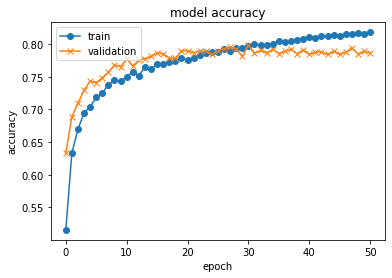

In [18]:
# Plotagem da acurácia de Treinamento e Validação
plt.figure(1)
plt.plot(hist.history['accuracy'], 'o-')
plt.plot(hist.history['val_accuracy'], 'x-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 8. Arquitetura da Rede Neural

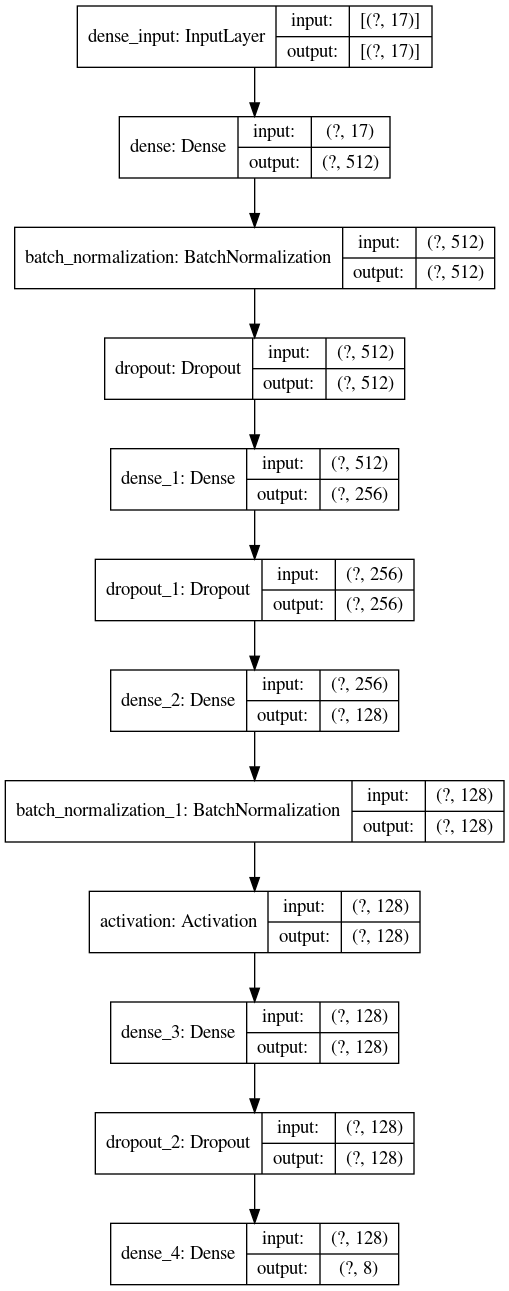

In [21]:
plot_model(model, to_file="5.1-modelo.png", show_shapes=True, show_layer_names=True)